# The Constrained Variational Quantum Eigensolver algorithm

In [1]:
from qiskit.opflow import Z, I, X, Y
from qiskit.opflow import CircuitStateFn, StateFn, CircuitSampler, PauliExpectation, ListOp
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.providers.aer import AerSimulator
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector
from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library.n_local import EfficientSU2, RealAmplitudes
from qiskit import Aer, execute, transpile

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

We take the Transverse Ising Hamiltonian with periodic boundary conditions :
\begin{equation}
H=J_z\sum_{i=0}^{1}\sigma_i^z\sigma_{i+1}^z + h\sum_{i=0}^{2}\sigma_i^x,
\end{equation}


In [2]:
# implement the Transverse Ising Hamiltonian H with periodic bounday conditions and parameters N, J and h.

N = 3
h = 1
J = 1


H = J* ( (Z^Z^I) + (I^Z^Z) ) + h *(( X^I^I) + ( I^X^I) + ( I^I^X))



H = H.reduce() 


1.0 * ZZI
+ 1.0 * IZZ
+ 1.0 * XII
+ 1.0 * IXI
+ 1.0 * IIX


In [6]:


n_qubits = 3
params = ParameterVector('θ',(n_qubits*6))

qr = QuantumRegister(n_qubits)
ansatz = QuantumCircuit(qr)


       
ansatz.compose(EfficientSU2(3, reps=1, insert_barriers=True).decompose(), inplace=True)
ansatz.draw()


# use SU2 Ansatz
    

┌──────────┐┌──────────┐ ░                 ░ ┌──────────┐ ┌──────────┐
q1_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├─░───■────■────────░─┤ Ry(θ[6]) ├─┤ Rz(θ[9]) ├
      ├──────────┤├──────────┤ ░ ┌─┴─┐  │        ░ ├──────────┤┌┴──────────┤
q1_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├─░─┤ X ├──┼────■───░─┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├
      ├──────────┤├──────────┤ ░ └───┘┌─┴─┐┌─┴─┐ ░ ├──────────┤├───────────┤
q1_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─░──────┤ X ├┤ X ├─░─┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├
      └──────────┘└──────────┘ ░      └───┘└───┘ ░ └──────────┘└───────────┘

### The VQE algorithm

In [13]:
### Implementation with Qiskit modules (written by Julien to demonstrate the advantage of Qiskit builtin functions)


from qiskit.algorithms import VQE as QiskitVQE
from qiskit.algorithms.optimizers import SPSA

vqe = QiskitVQE(ansatz, SPSA(), quantum_instance= Aer.get_backend('qasm_simulator'))
result = vqe.compute_minimum_eigenvalue(H)

C:\Users\vince\.conda\envs\q_env\lib\site-packages\sympy\core\expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


In [14]:
opt_circuit = ansatz.bind_parameters(result.optimal_parameters)
sampler = CircuitSampler(Aer.get_backend('qasm_simulator'))

def overlap(theta):
    expr = StateFn(opt_circuit).adjoint() @ StateFn(ansatz.bind_parameters(theta))
    exp = PauliExpectation().convert(expr)
    return np.abs(sampler.convert(exp).eval()) ** 2

In [15]:
energy = vqe.get_energy_evaluation(H)

def objective(theta):
    return energy(theta) + 2 * overlap(theta)

res = SPSA().optimize(1, objective, initial_point = np.pi * np.random.normal(0,1,size = len(ansatz.parameters)))


In [16]:
print(res)



(array([ 0.11694058, -3.0815028 ,  4.16561148, -2.3187025 ,  1.19466155,
        0.95748962, -2.54543286,  2.66601361,  3.45751739, -5.95875447,
        0.11767189,  2.03868092]), -2.888671875, 200)


In [17]:
## code we used during the Hackathon 


noise_model = None # the noise model used to simulate the hardware, for now, leave it to None (no noise)


class VQE:
    def __init__(self,ansatz, qr, H):
        self.H = H
        self.qr = qr
        self.backend = Aer.get_backend('qasm_simulator',noise = noise_model)
        self.ansatz = transpile(ansatz, self.backend)
        self.shots = 2**12 # number of sample used to approximate the expectation value
        #choose some classical optimizer. You may take a gradient based or gradient free optimizer 
        # and play with the hyperparameters as well.
        self.optimizer = ADAM(maxiter=1, tol=1e-06, lr=0.02, beta_1=0.9, beta_2=0.99, amsgrad=False)
        
        self.lesser_eigenstate_parameters = [] # list to contain previously computed parameters
        self.constraint_multiplier = 10 
   

    def overlap(self, parameters, other_state_parameters):
        """ 
        return the overlap between a state given by specific parameters
        """
        
        # to find the overlap < phi_0 | phi_1 > we need to construct a circuit that measures
        # < "000" | U_0 *  U_1 | "000" > where U are the unitary evolution operators
        
        total_overlap = 0
        
        
        for i in range(len(self.H)): #loop over the pauli terms
            
            
             # construct U_0 * 
            
            second_circuit = self.ansatz.copy()
        
            second_circuit = second_circuit.bind_parameters(other_state_parameters) 

            second_circuit = second_circuit.inverse()

             # compose U_0 * with U_1
                
                
            additional_circuit = self.ansatz.copy()
            additional_circuit = additional_circuit.bind_parameters(parameters)

            second_circuit.compose(  self.ansatz.copy()  ) 

            
            coeff = self.H[i].primitive.coeffs                 # get the coefficients
            pauli = self.H[i].primitive.table.to_labels()[0]   #get the pauli string
            
            observable, measure_which = self.basis_change(pauli)  #get which qubits to measure and the basis change
            
            second_circuit.append(observable,self.qr)  # append the basis change
            second_circuit.measure_all()          # measure all the qubits
            
            job = execute(second_circuit, self.backend, shots=self.shots)
            
            counts = job.result().get_counts()
            
            # count "000" ( aka project onto the |"000"> state)
            # that probability gives the total overlap
            
            if "000" in counts: 
                total_overlap += coeff * counts["000"] / np.sum([counts[key] for key in counts])
                
        # return the total overlap  
        return total_overlap.real
        
        
        
        
        
        
        
    def expectation_value(self,parameters):
    
        '''
        return the expectation value of the quantum circuit wrt to the observable H
        
        '''
      
        result = 0
        
        for i in range(len(self.H)): #loop over the pauli terms
            ansatz = self.ansatz.bind_parameters(parameters)   #insert the parameters
            coeff = self.H[i].primitive.coeffs                 # get the coefficient
            pauli = self.H[i].primitive.table.to_labels()[0]   #get the pauli string
            
            observable, measure_which = self.basis_change(pauli)  #get which qubits to measure and the basis change
            
            ansatz.append(observable,self.qr)  # append the basis change
            ansatz.measure_all()          # measure all the qubits
            
            job = execute(ansatz, self.backend, shots=self.shots)
            
            counts = job.result().get_counts()
            
            result = result + coeff * self.expectation_from_counts(counts,measure_which) 
            
        for i, other_state_parameters in enumerate(self.lesser_eigenstate_parameters) :
            result += self.constraint_multiplier * self.overlap(parameters, other_state_parameters)
            
            
            
            
        return result.real
    
    def basis_change(self,pauli):
        '''transform the measurement basis as function of the observable
        return: -quantum circuit to append to the ansatz
                -qubit to measure
        '''
        observable = QuantumCircuit(len(pauli))   #the basis transformation circuit U to append to the ansatz
        
        measure_which = []  #which qubit we will have to measure
        for i in range(len(pauli)):
            if pauli[i] == "I":
                continue 
            else:
                measure_which.append(i)
                if pauli[i] == "X":
                    observable.h(i)
                
            
        return observable, measure_which
    
    def expectation_from_counts(self,counts,measure_which):
        '''compute the expectation value from counts
        Tipp: look at the parity of the state
        remember: in qiskit we read the qubits from right to left

        '''
        
        total_counts = np.sum([counts[key] for key in counts])
        expectation = 0
        
        if len(measure_which)==0:
            return 1
        # return the expectation value when the pauli is the identity
        
        for i,state in enumerate(counts):
            
            parity = (-1)**np.sum([int(state[k]) for k in range(len(state)) if (len(state)- 1 - k) in measure_which ])
            # your code goes here, compute the parity of the state
            expectation = expectation + parity * counts[state]
        
        return expectation / total_counts
    
    def gradient(self,parameters):
        '''
        return the gradient of the quantum circuit 
        
        '''
        
        gradients = np.zeros_like(parameters)
        for i,p in enumerate(parameters):
           
            shift = np.zeros_like(parameters)
            shift[i] = np.pi/2
            gradients[i] = (1/2) * (self.expectation_value( parameters + shift ) - (self.expectation_value(parameters-shift)))
        
        return gradients
    
    def update(self,parameters):
        '''
        update the parameters with the classical optimizer
        
        '''
        parameters, loss, it = self.optimizer.optimize(parameters.size,
                        lambda param: self.expectation_value(param),
                        gradient_function= lambda param: self.gradient(param),initial_point=parameters)
        
        return loss, parameters
 

        

In [18]:
%matplotlib notebook


# The following functions compute the excited states. 
# Sadly they are very long computations. 
# To converge succesfully, about 130 iterations are needed which takes over an hour

# Below you can see plots which show the results after 50 iterations


def constrained_Hamiltonian(H, order, a):
    """
    Function that uses the constrained VQE to compute different orders of excited states
    
    Inputs :
    H : base Hamiltonian
    order : which eigenvalue we're looking for
    a : multiplier coefficient
    """
    plt.ion()
    fig = plt.figure()
    fig.show()
    fig.canvas.draw()
    
    vqe  = VQE(ansatz, qr, H)
    
    vqe.constraint_multiplier = a
    
    losses = []
    
    eigen = np.linalg.eig(H.to_matrix())
    exact_eigenvalues = np.sort(np.real(eigen[0]))
    
    
    
    for i in range(order):
        
        
        print(f"Constructing Hamiltonian and computing ground state of order {i}.")
        print(f"Exact eigenvalue computed : {exact_eigenvalues[i]} eV")
        
        
        ax = fig.add_subplot(111)
        
        vec , l = iterate_to_eigenvector(H, vqe, ax, fig, exact_eigenvalues[i])
        losses.append(l)
        vqe.lesser_eigenstate_parameters.append(vec)
        
        print(f"The quantum algorithm converged to {l[-1]}")
    
    return vqe, losses, exact_eigenvalues
    

def iterate_to_eigenvector(Hm, vqe, ax, fig , exact_energy, maxiter = 100):
    """
    Iterates to ground state of a Hamiltonian, returns the eigenvector
    
    Inputs:
    H : Hamiltonian
    ax : axis on which to draw
    fig : figure on which to draw
    maxiter : maximum number of iterations
    
    """
    
    # select a starting vector according to a random initial vector 
    
    v0 = np.pi * np.random.normal(0,1,size = len(ansatz.parameters))
    
    vqe.optimizer.set_options(kwargs = { "lr" , 0.08}) # set learning rate to 0.08
    
    
    
    print("Computing Eigenvector for new Hamiltonian")
    
    loss = []
    for i in tqdm(range(maxiter)):
        l , v0 = vqe.update(v0)
        loss.append(l)
        if i == 40 :
            vqe.optimizer.set_options(kwargs = { "lr" , 0.02})
        if i == 60:
            vqe.optimizer.set_options(kwargs = { "lr" , 0.001})
        
        ax.clear()
        ax.plot(loss,'b.',label='VQE')
 
        ax.plot(exact_energy*np.ones_like(range(maxiter+1)),'k--',label='exact')
        ax.legend()
        ax.set_xlim([-0.2, maxiter])
        ax.set_ylim([-4, max(loss) + 1])
        fig.canvas.draw()
        
    return v0 , loss

<IPython.core.display.Javascript object>


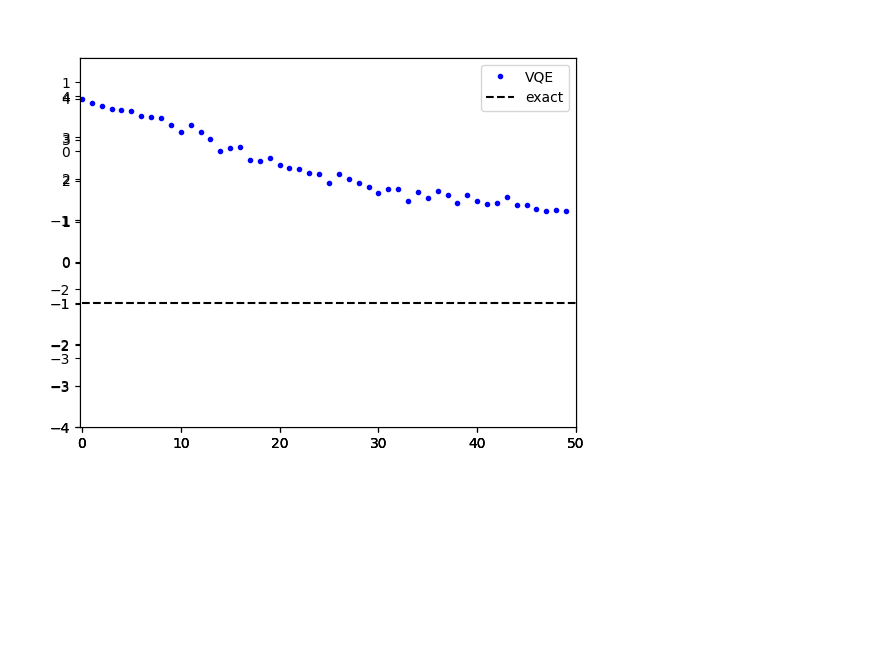

Constructing Hamiltonian and computing ground state of order 0.
Exact eigenvalue computed : -3.493959207434937 eV
Computing Eigenvector for new Hamiltonian


  0%|          | 0/50 [00:00<?, ?it/s]

The quantum algorithm converged to [-3.26171875]
Constructing Hamiltonian and computing ground state of order 1.
Exact eigenvalue computed : -2.6038754716096744 eV
Computing Eigenvector for new Hamiltonian


  0%|          | 0/50 [00:00<?, ?it/s]

The quantum algorithm converged to [0.3828125]
Constructing Hamiltonian and computing ground state of order 2.
Exact eigenvalue computed : -1.0 eV
Computing Eigenvector for new Hamiltonian


  0%|          | 0/50 [00:00<?, ?it/s]

The quantum algorithm converged to [1.22021484]


In [19]:
v, losses, exact_eigenvalues = constrained_Hamiltonian(H, 3, 10)

# the graph below was just to see the convergence live , the actual results are further below

<IPython.core.display.Javascript object>


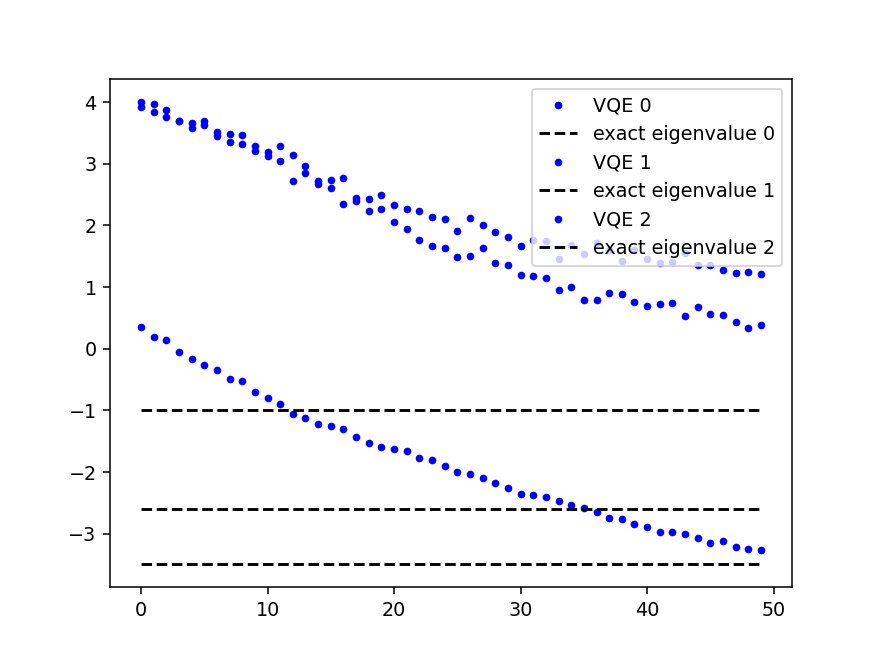

In [23]:


## The figure below shows the convergence
# Although converging to the ground state was relatively accurate, the |1> and |2> states are very inaccurate
# this is likely because the error from the ground state carries over, 
# and because the lagrange multiplier needs more iterations to converge

fig = plt.figure()
for i, loss in enumerate(losses):
    plt.plot(range(50), loss,'b.',label=f'VQE {i}')
    plt.plot(exact_eigenvalues[i]*np.ones_like(range(50)),'k--',label=f'exact eigenvalue {i}')
    
plt.legend(loc= "best")